## Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Linear regression

### The normal equation

In [2]:
np.random.seed(42)  # for the sake of reproducibility

m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)

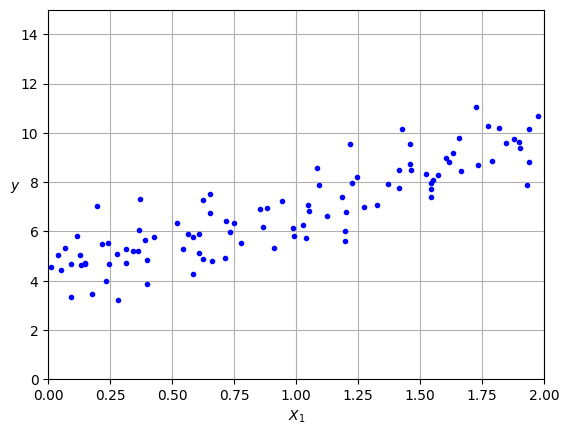

In [3]:
plt.plot(X, y, "b.")

plt.xlabel("$X_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.axis([0, 2, 0, 15])

plt.show()

In [4]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [6]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

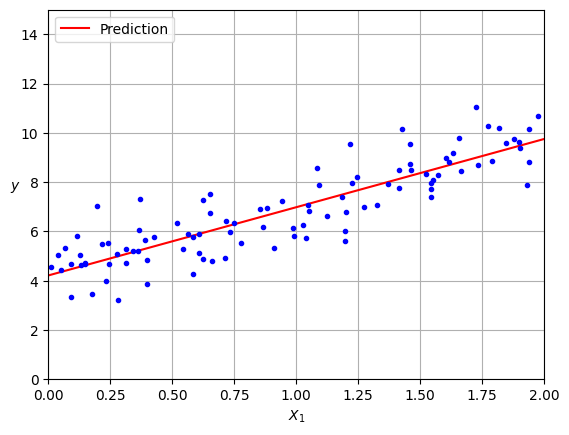

In [7]:
plt.plot(X_new, y_predict, "r-", label="Prediction")
plt.plot(X, y, "b.")

plt.xlabel("$X_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.axis([0, 2, 0, 15])
plt.legend(loc="upper left")

plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [9]:
lin_reg.coef_

array([[2.77011339]])

In [10]:
lin_reg.intercept_

array([4.21509616])

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

LinearRegression class is based on scipy.linalg.lstsq() function (the name stands for "least square"). We can call it directly using np.linalg.lstsq().

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best

array([[4.21509616],
       [2.77011339]])

This function compute $\hat{\theta} = X^+y$ where $X^+$ is the *pseudoinverse* of X (specifically, the Moore-Penrose inverse). We can use np.linalg.pinv() to directly compute the pseudoinverse.

In [13]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

## Gradient descent

In [14]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    gradient = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradient

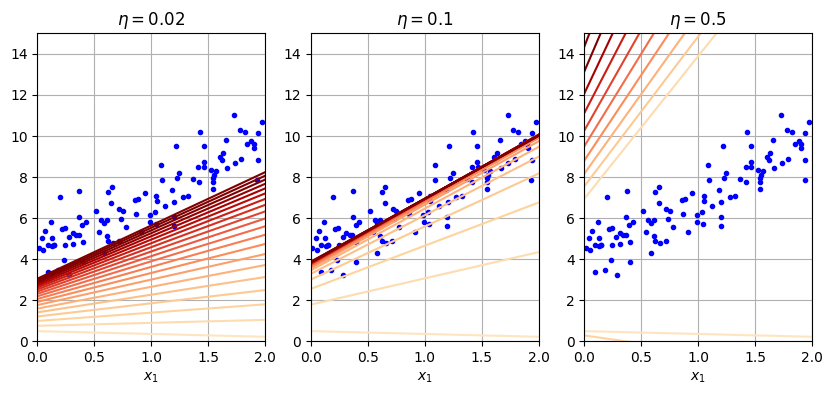

In [15]:
import matplotlib


def plot_gradient_descent(theta, eta):
    m = len(X_b)
    n_epochs = 1000
    n_shown = 20
    plt.plot(X, y, "b.")
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = matplotlib.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradient = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradient
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(rf"$\eta = {eta}$")
    return theta_path


np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.xlabel("$x_1$")
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)  # save for later comparison
plt.xlabel("$x_1$")
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
plt.xlabel("$x_1$")
plt.show()

## Stochastic Gradient Descent

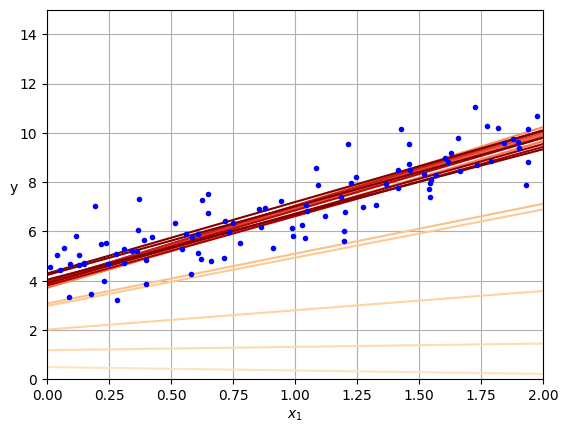

In [16]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameter


def learning_schedule(t):
    return t0 / (t1 + t)


np.random.seed(42)
theta = np.random.randn(2, 1)

n_shown = 20
theta_path_sgd = []

for epoch in range(n_epochs):
    for iteration in range(m):
        if epoch == 0 and iteration < n_shown:
            y_predcit = X_new_b @ theta
            color = matplotlib.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predcit, linestyle="solid", color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]

        gradient = 2 * xi.T @ (xi @ theta - yi)  # we train on 1 instance so m = 1
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradient
        theta_path_sgd.append(theta)


plt.plot(X, y, "b.")
plt.grid()
plt.axis([0, 2, 0, 15])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.show()

Here we train on a random instance, but an instance can be choose multiple times. But because we choose randomly, the result would be the same as we make sure every chosen instance. If you want to approach that way, you can shuffle the index, go through the train set, then shuffle and train again and again.

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

You can use SGDRegressor class in Scikit-learn instead of implement SGD from scratch. It default to use MSE for scoring. <br>
The following code:
- run for maximum 1000 epochs (max_iter) or until the loss drops by less than $10^{-5}$ (tol) during the first 100 epochs (n_iter_no_change). 
- It start with the learning rate of 0.01 (eta0), using the default learning schedule (which is different from the one we used). 
- Lastly, it does not use any regularization (penalty=None, more on that later).

In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-5,
    penalty=None,
    eta0=0.01,
    n_iter_no_change=100,
    random_state=42,
)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expect 1D array

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## Mini-batch Gradient Descent

In [20]:
from math import ceil

n_epochs = 50
minibatch_sizes = 20
n_batches_per_epoch = ceil(m / minibatch_sizes)

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000


def learning_schedule(t):
    return t0 / (t + t1)


theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        index = minibatch_sizes * iteration
        xi = X_b_shuffled[index : index + minibatch_sizes]
        yi = y_shuffled[index : index + minibatch_sizes]

        gradient = 2 / minibatch_sizes * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradient
        theta_path_mgd.append(theta)

In [21]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

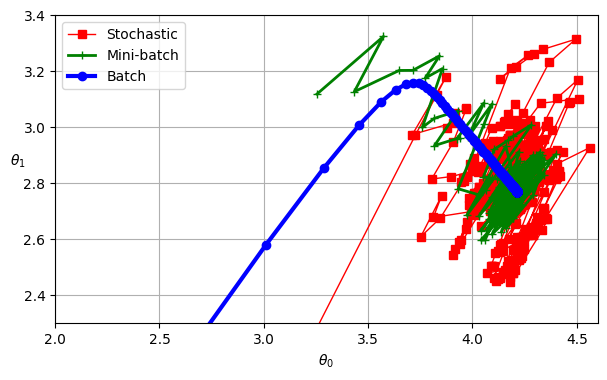

In [22]:
plt.figure(figsize=(7, 4))
plt.plot(
    theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1.0, label="Stochastic"
)
plt.plot(
    theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2.0, label="Mini-batch"
)
plt.plot(
    theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3.0, label="Batch"
)

plt.legend(loc="upper left")
plt.axis([2.0, 4.6, 2.3, 3.4])
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation=0)
plt.grid()
plt.show()

## Polynomial Regression

In [23]:
np.random.seed(42)

m = 100  # number of instances
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

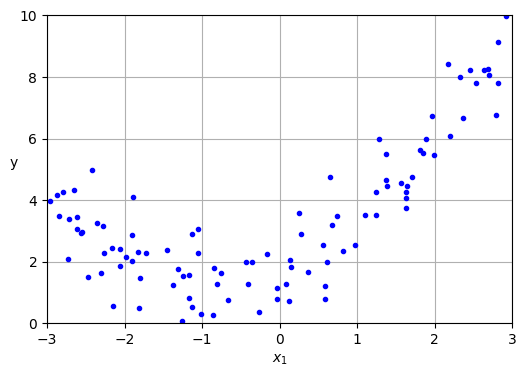

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.grid()
plt.show()

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [26]:
X[0]

array([-0.75275929])

In [27]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly now contains the original feature plus the square of this feature.

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [29]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

So the model estimates $\hat{y} = 0.56.x^2+0.93.x+1.78$ when in fact the underlying function is $y = 0.5.x^2+x+2+$ Gaussian noise.

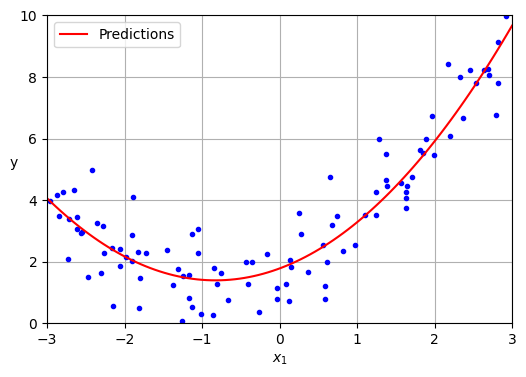

In [30]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")

plt.legend(loc="upper left")
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.show()

## Learning curves

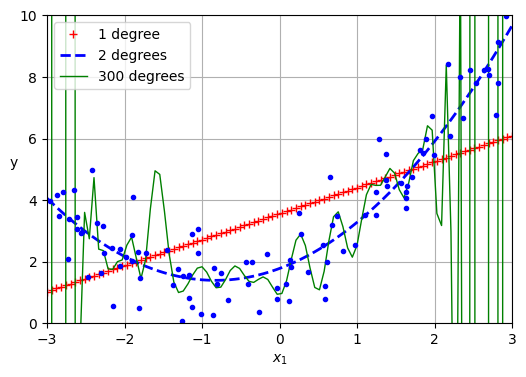

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in [("r+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)]:
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.")
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.grid()
plt.show()

Scikit-learn has learning_curve() function to help: It automatically trains and evaluates the model using cross-validation. 

It trains the model on growing subsets of the training set by default, but if the model support incrementally learning, then you can set exploit_incremental_learning=True when calling learning_curve() and it will train the model incrementally instead.

The function returns the training set size at which it evaluated the model, the training and validation score for each size and for each cross-validation fold.  

In [32]:
from sklearn.model_selection import learning_curve

train_size, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

In [33]:
train_error = -train_scores.mean(axis=1)
valid_error = -valid_scores.mean(axis=1)

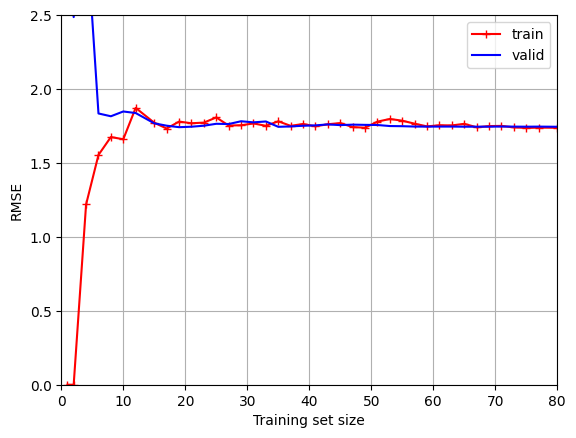

In [34]:
plt.plot(train_size, train_error, "r-+", label="train")
plt.plot(train_size, valid_error, "b-", label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.axis([0, 80, 0.0, 2.5])
plt.grid()
plt.show()

Now we train a 10th-degree polynomial model.

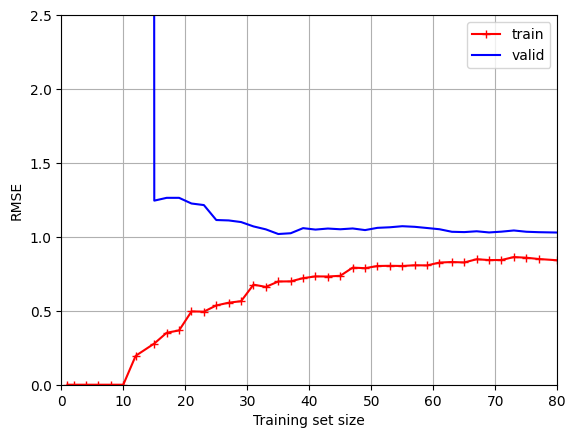

In [36]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False), LinearRegression()
)

train_size, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

train_error = -train_scores.mean(axis=1)
valid_error = -valid_scores.mean(axis=1)

plt.plot(train_size, train_error, "r-+", label="train")
plt.plot(train_size, valid_error, "b-", label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.axis([0, 80, 0.0, 2.5])
plt.grid()
plt.show()